### Ian Gilman
### CBB 555 Problem Set 3: Feed-Forward Neural Networks and Autoencoders
### 28 November 2017

Neural networks provide a flexible framework for supervised and unsupervised learning and are increasingly employed in biology. Their flexibility stems from the user's ability to manipulate layer parameters such number of nodes and activation functions, as well as global parameters such as connectivity between layers, loss functions, and learning rate. Among the most common uses for neural networks in bioinformatics are DNA sequence alignment (Andreatta and Nielsen 2015), protein binding site prediction and biochemistry (Shen and Bax 2013), and data visualization (presented here). Here we demonstrate the utility of neural networks in classification and data visualization with logisitic regression, feed forward neural networks, and autoencoders on the MNIST dataset and an empirical dataset from mass cytometry data from bone marrow blood collected by Bendall et al. (2011). 

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
plt.style.use('seaborn-white')
from tensorflow.examples.tutorials.mnist import input_data
from tqdm import tqdm_notebook
import codecs, json, sys
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances

In [2]:
def load_json_files(file_path):
    '''
    Loads data from a json file
    Inputs:
        file_path   the path of the .json file that you want to read in
    Outputs:
        my_array    this is a numpy array if data is numeric, 
                                it's a list if it's a string'''
    #  load data from json file
    obj_text = codecs.open(file_path, 'r', encoding='utf-8').read()
    b_new = json.loads(obj_text)

    # FIXED BUG: simple (but not elegant) hack to make this work 
    # for both python versions
    # Python 2 ==> reads the json as unicode so we have to change it
    # Python 3 ==> is smarter and reads the json as ascii
    if sys.version_info[0] is 2:
        # if a string, then returns list of strings
        if type(b_new[0]) is unicode:
            # translate from unicode to ascii
            my_array = [b.encode('ascii','ignore') for b in b_new]
        # otherwise, it's assumed to be numeric and returns numpy array
        else:
            my_array = np.array(b_new)
    else:
        # if a string, then returns list of strings
        if type(b_new[0]) is str:
            my_array = b_new  # just return
        # otherwise, it's assumed to be numeric and returns numpy array
        else:
            my_array = np.array(b_new)

    return my_array

## 1. MNIST Classification
The MNIST dataset consists of tens of thousands of handwritten digits transformed into 28x28 grids of pixels whose cells correspond to gray values, such as the one below. Each datapoint has an associated integer label.

In [3]:
mnist = input_data.read_data_sets("data/MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


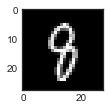

In [14]:
fig = plt.figure(figsize=(1.5,1.5))
plt.imshow(mnist.train.images[1].reshape((28, 28)), cmap=plt.cm.gray)

### 1.1 Logistic regression
Our first task will be to construct a neural network that can correctly classify these images by digit. We'll do this using logistic regression and begin with a learning rate ($\eta$) of 0.5 and a single output layer with 10 nodes corresponding to the 10 possible digits. We will use categorical cross entropy as our loss function and optimize using stochastic gradient descent. Finally, we'll sample every 10 epochs to measure the increase in accuracy over time (in training steps).

In [5]:
def nn_W(shape):
    '''Creates a weight variable
    
    Parameters
    ----------
    shape: size of input vector'''
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

In [6]:
def nn_b(shape):
    '''Creates a bias variable
    
    Parameters:
    -----------
    shape: size of output vector'''
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

In [7]:
def layer_mult(x, input_shape, output_shape):
    '''Returns linear transformation of x using weight 
    matrix and bias vector
    
    Parameters
    ----------
    x: input vector
    input_shape: size of input vector
    output_shape: size of output vector'''
    W = nn_W([input_shape, output_shape])
    b = nn_b([output_shape])
    return tf.matmul(x, W) + b

In [8]:
def classifier1(input_shape, output_shape, eta=0.5, 
                batch_size=100, sample_every=10, epochs=1000):
    '''Classifies MNIST data via logistic regression and 
    returns the accuracy of the classifier
    
    Parameters
    ----------
    input_shape: size of input vector
    output_shape: size of output vector
    eta: learning rate (default=0.5)
    batch_size: batch size for training
    sample_every: sampling frequency
    epochs: number of training iterations'''
    # None is given a placeholder dimension so it can be varied later
    x = tf.placeholder(tf.float32, [None, input_shape])
    # Create a placeholder for correct answers
    y_ = tf.placeholder(tf.float32, [None, output_shape])

    # Using tf.add let's us name our variable for downstreams 
    # visualization and debugging
    y = tf.nn.softmax(layer_mult(x, input_shape, output_shape))
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, 
                labels=y_, name='loss'), name='avg_loss')
    # Now well create the optimizer that will do our gradient descent
    # The way we set this up, tf knows we want to update w and b, 
    # but we can change thiswith var_list. It knows this because 
    # those are the variables associated with the loss function
    train_step = tf.train.GradientDescentOptimizer(
        learning_rate=eta).minimize(loss=loss)
    accuracies = []
    with tf.Session() as sess:
        # Initialize variables from above
        sess.run(tf.global_variables_initializer())
        # Training loop
        for step in tqdm_notebook(range(epochs), leave=False):
            batch_x, batch_y = mnist.train.next_batch(batch_size=batch_size)
            train_step.run(feed_dict={x: batch_x, y_:batch_y})
            # Sample accuracy
            if step%sample_every==0:
                correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
                tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, 
                                                     tf.float32))
                accuracy = sess.run(tf_accuracy, 
                    feed_dict={x: mnist.test.images, y_: mnist.test.labels})
                accuracies.append(accuracy)
    print('Final accuracy: %f') % (accuracies[-1])
    return accuracies

In [9]:
tf.reset_default_graph()
logreg_acc = classifier1(input_shape=784, output_shape=10, 
                         sample_every=50, epochs=5000)

Final accuracy: 0.920800


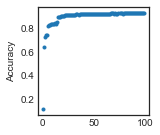

In [15]:
fig, ax = plt.subplots(figsize=(2,2))
ax.scatter(x=range(len(logreg_acc)), y=logreg_acc, marker='.')
ax.set_ylabel('Accuracy')

With our simple logistic regression classifier we achieved an accuracy of about 92%. Although we can classify handwritten digits with over 90% accuracy, typical scores on the MNIST data approach 97-99% accuracy through the addition of hidden layers, manipulation of $\eta$, and exprimentation with other activation and loss functions. Next we will create a feed-forward neural network with a single hidden layer to explore the effects of these parameters.
### 1.2 Feed-forward neural network
We will add a single hidden layer with 128 nodes between the input and output layers to our logistic regression classifier and add two parameters that allow us to change the activation functions.

In [19]:
def classifier2(h1_act ='sigmoid', y_act='sigmoid', eta=0.5, 
              input_shape=784, width=128, output_shape=10, 
              batch_size=100, epochs=1000, sample_every=100):
    '''Classifies MNIST data via a feed-forward neural network
    
    Parameters
    ----------
    h1_act: hidden layer activation function (default='sigmoid')
    y_act: output layer activation function (default='sigmoid')
    eta: learning rate (default=0.5)
    input_shape: size of input vector (default=784)
    width: width of hidden layer (default=128)
    output_shape: size of output vector (default=10)
    batch_size: batch size for training
    epochs: number of training iterations
    sample_every: sampling frequency'''
    # Reset any old graphs
    tf.reset_default_graph()

    x = tf.placeholder(shape=[None,784], dtype=tf.float32)
    y_ = tf.placeholder(shape=[None,10], dtype=tf.float32)
    # Switches for activation functions
    if h1_act=='linear': h1 = tf.nn.softmax(layer_mult(x, input_shape, width))
    if h1_act=='sigmoid': h1 = tf.nn.sigmoid(layer_mult(x, input_shape, width))
    if h1_act=='relu': h1 = tf.nn.relu(layer_mult(x, input_shape, width))
    if h1_act=='tanh': h1 = tf.nn.tanh(layer_mult(x, input_shape, width))
    if h1_act=='elu': h1 = tf.nn.elu(layer_mult(x, input_shape, width))
    if h1_act=='softplus': h1 = tf.nn.softplus(layer_mult(x, input_shape, width))
        
    if y_act=='linear': y = tf.nn.softmax(layer_mult(h1, width, output_shape))
    if y_act=='sigmoid': y = tf.nn.sigmoid(layer_mult(h1, width, output_shape))
    if y_act=='relu': y = tf.nn.relu(layer_mult(h1, width, output_shape))
    if y_act=='tanh': y = tf.nn.tanh(layer_mult(h1, width, output_shape))
    if y_act=='elu': y = tf.nn.elu(layer_mult(h1, width, output_shape))
    if y_act=='softplut': y = tf.nn.softplus(layer_mult(h1, width, output_shape))
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, 
                            labels=y_, name='loss'), name='avg_loss')
    train_step = tf.train.GradientDescentOptimizer(
            learning_rate=eta).minimize(loss=loss)

    accuracies = []
    batch_size = batch_size
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in tqdm_notebook(range(epochs), leave=False):
            batch_x, batch_y = mnist.train.next_batch(batch_size=batch_size)
            train_step.run(feed_dict={x:batch_x, y_:batch_y})

            if step%sample_every==0:
                predictions = np.argmax(sess.run(
                    y, feed_dict={x: mnist.test.images,
                                  y_: mnist.test.labels}), axis=1)
                correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
                tf_accuracy = tf.reduce_mean(
                    tf.cast(correct_prediction, tf.float32))
                accuracy = sess.run(tf_accuracy, 
                            feed_dict={x: mnist.test.images, 
                                       y_: mnist.test.labels})
                accuracies.append(accuracy)

    return accuracies, predictions, np.argmax(mnist.test.labels, axis=1)

First, we can alter the activation function before the hidden layer, after the hidden layer, or both before and after. In the top left panel of the figure below we see that the greatest accuracy was most quickly achieved using a sigmoid activation function before and after the hidden layer.

In [20]:
ff_lin_sig_acc, ff_lin_sig_pred, ff_lin_sig_truth = classifier2(
    h1_act ='linear', epochs=10000, sample_every=100)
ff_sig_lin_acc, ff_sig_lin_pred, ff_sig_lin_truth = classifier2(
    y_act='linear', epochs=10000, sample_every=100)
ff_sig_sig_acc, ff_sig_sig_pred, ff_sig_sig_truth = classifier2(
    epochs=10000, sample_every=100)

Second, we will alter the learning rate, $\eta$, to examine how efficiently we are optimizing our loss function. A small learning rate may converge to a local minimum but a large learning rate may not converge at all. The top right panel of the figure below shows a general trend of higher learning rates leading to higher accuracy when using a sigmoid activiation function before and after the hidden layer. This is unexpected as $\eta=0.5$ is already a moderately large learning rate. Some accuracy curves showed discontinuous jumps; therefore it may be that smaller learning rates will approach or exceed the accuracy of networks with larger learn rates but that behavior was not found, even over 10,000 epochs.

In [21]:
ff_sig_0001_acc, ff_sig_0001_pred, ff_sig_0001_truth = classifier2(
    eta=0.0001, epochs=10000, sample_every=100)
ff_sig_001_acc, ff_sig_001_pred, ff_sig_001_truth = classifier2(
    eta=0.01, epochs=10000, sample_every=100)
ff_sig_05_acc, ff_sig_05_pred, ff_sig_05_truth = classifier2(
    eta=0.05, epochs=10000, sample_every=100)
ff_sig_10_acc, ff_sig_10_pred, ff_sig_10_truth = classifier2(
    eta=0.1, epochs=10000, sample_every=100)
ff_sig_30_acc, ff_sig_30_pred, ff_sig_30_truth = classifier2(
    eta=0.3, epochs=10000, sample_every=100)
ff_sig_70_acc, ff_sig_70_pred, ff_sig_70_truth = classifier2(
    eta=0.7, epochs=10000, sample_every=100)

Next, we will test the affects of using different activation functions before our hidden layer. We will keep $\eta=0.7$ and substitute the first sigmoid function for 1) tanh, 2) relu, 3) softplus, and 4) elu. All activation functions produced very similar final accuracies within just a few epochs, although the relu+sigmoid network produced the final accuracy of ~97%.

In [22]:
ff_tanh_sig_acc, ff_tanh_sig_pred, ff_tanh_sig_truth = classifier2(
    h1_act ='tanh', eta=0.7, epochs=10000, sample_every=100)
ff_relu_sig_acc, ff_relu_sig_pred, ff_relu_sig_truth = classifier2(
    h1_act ='relu', eta=0.7, epochs=10000, sample_every=100)
ff_sp_sig_acc, ff_sp_sig_pred, ff_sp_sig_truth = classifier2(
    h1_act ='softplus', eta=0.7, epochs=10000, sample_every=100)
ff_elu_sig_acc, ff_elu_sig_pred, ff_elu_sig_truth = classifier2(
    h1_act ='elu', eta=0.7, epochs=10000, sample_every=100)

Finally, we can see the effects of the hidden layer width by multiplying the original 128-unit layer by factors of 2. We find only slight differences between the layer widths but the runtime for the smallest layer width was 1-2 minutes faster than for the largest layer width (bottom right panel, below).

In [23]:
ff_w64_acc, ff_w64_pred, ff_w64_truth = classifier2(h1_act='relu',
    eta=0.7, width=64, epochs=10000, sample_every=100)
ff_w256_acc, ff_w256_pred, ff_w256_truth = classifier2(h1_act='relu',
    eta=0.7, width=256, epochs=10000, sample_every=100)
ff_w512_acc, ff_w512_pred, ff_w512_truth = classifier2(h1_act='relu',
    eta=0.7, width=512, epochs=10000, sample_every=100)
ff_w1024_acc, ff_w1024_pred, ff_w1024_truth = classifier2(h1_act='relu',
    eta=0.7, width=1024, epochs=10000, sample_every=100)

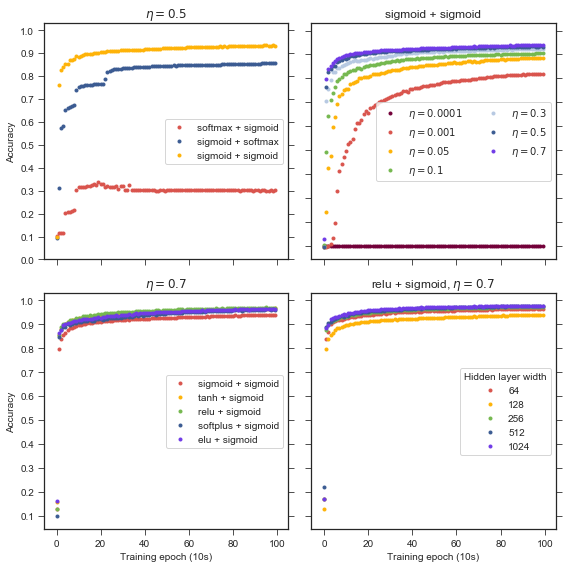

In [24]:
fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(2,2, 
                            figsize=(8,8), sharex=True, sharey=True)

ax.scatter(x=range(len(ff_lin_sig_acc)), y=ff_lin_sig_acc, marker='.', 
           color='xkcd:pale red', label='softmax + sigmoid')
ax.scatter(x=range(len(ff_sig_lin_acc)), y=ff_sig_lin_acc, marker='.', 
           color='xkcd:denim blue', label='sigmoid + softmax')
ax.scatter(x=range(len(ff_sig_sig_acc)), y=ff_sig_sig_acc, marker='.', 
           color='xkcd:amber', label='sigmoid + sigmoid')
ax2.scatter(x=range(len(ff_sig_0001_acc)), y=ff_sig_0001_acc, marker='.', 
            color='xkcd:merlot', label='$\eta=0.0001$')
ax2.scatter(x=range(len(ff_sig_001_acc)), y=ff_sig_001_acc, marker='.', 
            color='xkcd:pale red', label='$\eta=0.001$')
ax2.scatter(x=range(len(ff_sig_05_acc)), y=ff_sig_05_acc, marker='.', 
            color='xkcd:amber', label='$\eta=0.05$')
ax2.scatter(x=range(len(ff_sig_10_acc)), y=ff_sig_10_acc, marker='.', 
            color='xkcd:turtle green', label='$\eta=0.1$')
ax2.scatter(x=range(len(ff_sig_30_acc)), y=ff_sig_30_acc, marker='.', 
            color='xkcd:light blue grey', label='$\eta=0.3$')
ax2.scatter(x=range(len(ff_sig_sig_acc)), y=ff_sig_sig_acc, marker='.', 
            color='xkcd:denim blue', label='$\eta=0.5$')
ax2.scatter(x=range(len(ff_sig_70_acc)), y=ff_sig_70_acc, marker='.', 
            color='xkcd:bluish purple', label='$\eta=0.7$')
ax3.scatter(x=range(len(ff_sig_70_acc)), y=ff_sig_70_acc, marker='.', 
            color='xkcd:pale red', label='sigmoid + sigmoid')
ax3.scatter(x=range(len(ff_tanh_sig_acc)), y=ff_tanh_sig_acc, marker='.', 
            color='xkcd:amber', label='tanh + sigmoid')
ax3.scatter(x=range(len(ff_relu_sig_acc)), y=ff_relu_sig_acc, marker='.', 
            color='xkcd:turtle green', label='relu + sigmoid')
ax3.scatter(x=range(len(ff_sp_sig_acc)), y=ff_sp_sig_acc, marker='.', 
            color='xkcd:denim blue', label='softplus + sigmoid')
ax3.scatter(x=range(len(ff_elu_sig_acc)), y=ff_elu_sig_acc, marker='.', 
            color='xkcd:bluish purple', label='elu + sigmoid')
ax4.scatter(x=range(len(ff_w64_acc)), y=ff_w64_acc, marker='.', 
            color='xkcd:pale red', label='64')
ax4.scatter(x=range(len(ff_sig_70_acc)), y=ff_sig_70_acc, marker='.', 
            color='xkcd:amber', label='128')
ax4.scatter(x=range(len(ff_w256_acc)), y=ff_w256_acc, marker='.', 
            color='xkcd:turtle green', label='256')
ax4.scatter(x=range(len(ff_w512_acc)), y=ff_w512_acc, marker='.', 
            color='xkcd:denim blue', label='512')
ax4.scatter(x=range(len(ff_w1024_acc)), y=ff_w1024_acc, marker='.', 
            color='xkcd:bluish purple', label='1024')

ax.set_title('$\eta=0.5$')
ax.set_ylabel('Accuracy')
ax2.set_title('sigmoid + sigmoid')
ax3.set_xlabel('Training epoch (10s)')
ax3.set_title('$\eta=0.7$')
ax3.set_ylabel('Accuracy')
ax4.set_title('relu + sigmoid, $\eta=0.7$')
ax4.set_xlabel('Training epoch (10s)')

ax.legend(loc='center right', fontsize=10, frameon=True)
ax2.legend(loc = 'center right', frameon=True, fontsize=10, ncol=2)
ax3.legend(loc='center right', fontsize=10, frameon=True)
ax4.legend(title='Hidden layer width', loc='center right', 
           fontsize=10, frameon=True)
ax.set_yticks(np.round(np.linspace(start=0, stop=1.0, num=11), decimals=1))
for axis in [ax, ax2, ax3, ax4]:
    axis.yaxis.set_ticks_position('both')
    axis.tick_params(direction='out', length=6, axis='both', which='major')
plt.tight_layout()

Our best performing network was the relu+sigmoid activation functions using $\eta=0.7$ and a hidden layer width of 1024 units. This produced a final accuracy of 97.5% after 10,000 training epochs. We can more closely examine our networks strengths and weaknesses in classification by producing a confusion matrix, a matrix that shows the rate of misclassifcation between digits. We expect our model to easily discern certain digits, such as 0 and 1, and less easily discern more similar digits like 3 and 8. A heatmap showing the rate of misclassification is shown below, along with a bar chart showing the total rate of misclassification for each digit.

In [25]:
truths = ff_w1024_pred
classifications = ff_w1024_truth
conf_mat = np.zeros([10,10])
for t in range(len(truths)):
    if truths[t]!=classifications[t]:
        conf_mat[truths[t], classifications[t]]+=1

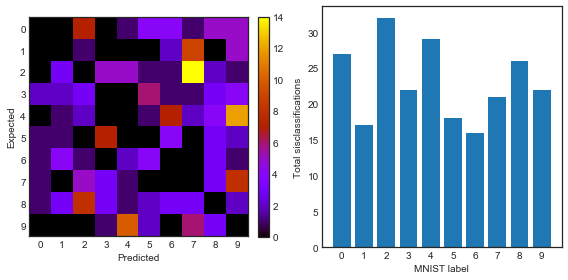

In [26]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
mymap = ax[0].imshow(conf_mat, cmap='gnuplot')

ax[0].set_xticks(range(10))
ax[0].set_yticks(range(10))
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Expected')

ax[1].bar(left=range(10), height=np.sum(conf_mat, axis=1))
ax[1].set_xticks(range(10))
ax[1].set_ylabel('Total sisclassifications')
ax[1].set_xlabel('MNIST label')

plt.colorbar(mymap, fraction=0.046, pad=0.04, ax=ax[0])
plt.tight_layout()

We see that the most confused digits pairs were (3,5) and (4,9). Unsurprisingly, 3 was the least misclassified digit despite its similarity in looping structures to 2, 5, 6, 8, and 9. 

## 2. Autoencoders
### 2.1 MNIST data
Autoencoders are an example of unsupervised learning that can indentify patterns in the data to reconstruct images similar to compression. Below we will define an autoencoder that compresses the input information from 784 units to just 2 (the encoding step) and then decodes the compressed information to form a new image of the original size (the decoding step). The shape of our network will be 784-1,000-500-250-2-25-500-1,000-784. Our autoencoder will (hopefully) learn to reproduce recognizable images of each digit. In addition to reproducing images, we can extract the embedding into the middle layer of the autoencoder, which projects our data into two dimensions. This projection can be used for clustering. Note that we have changed our optimizer from stochastic gradient descent to an ADAM optimizer.

In [27]:
def autoencoder1(input_shape, output_shape, epochs=1000, 
                            batch_size=100, eta=0.001):
    '''An autoencoder that recreates MNIST digits.
    
    Parameters
    ----------
    input_shape: size of input vector
    output_shape: size of output vector
    epochs: number of training iterations
    batch_size: batch size for training
    eta: learning rate (default=0.001)
    
    Returns
    -------
    middle_out: middle layer embedding
    image_out: output image reconstructions
    batch_img: MNIST images used for testing
    labels: MNIST labels used for testing'''
    tf.reset_default_graph()
    
    input_img = tf.placeholder(name='input_img', 
                shape=[None, input_shape], dtype=tf.float32)
    # Begin encoding
    e1 = tf.tanh(layer_mult(input_img, input_shape, 1000), name='e1')
    e2 = tf.tanh(layer_mult(e1, 1000, 500), name='e2')
    e3 = tf.tanh(layer_mult(e2, 500, 250), name='e3')
    middle = layer_mult(e3, 250, 2)
    # Begin decoding
    d1 = tf.tanh(layer_mult(middle, 2, 250), name='d1')
    d2 = tf.tanh(layer_mult(d1, 250, 500), name='d2')
    d3 = tf.tanh(layer_mult(d2, 500, 1000), name='d3')
    output_img = tf.nn.sigmoid(layer_mult(d3, 1000, output_shape), 
                               name='output_img')
    loss = tf.reduce_mean(tf.squared_difference(input_img, output_img), 
                          name='avg_loss')  
    train_step = tf.train.AdamOptimizer(eta).minimize(loss=loss)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in tqdm_notebook(range(epochs), leave=False):
            batch_img, batch_label = mnist.train.next_batch(batch_size)
            train_step.run(feed_dict={input_img:batch_img})

        # View middle layer
        batch_img, batch_label = mnist.test.next_batch(batch_size)
        middle_out = sess.run(middle, feed_dict={input_img: batch_img})
        pred = np.asarray(middle_out)
        labels = np.argmax(batch_label, axis=1)
        image_out = sess.run(output_img, feed_dict={input_img: batch_img})
    
    return middle_out, image_out, batch_img, labels

In [28]:
middle, decode, mnist_imgs, labels = autoencoder1(784, 784, epochs=10000)

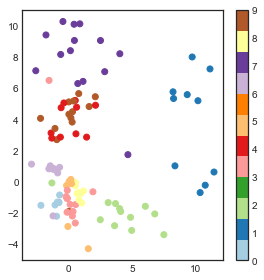

In [29]:
fig, ax = plt.subplots(figsize=(4,4))
ae_scat = ax.scatter(x=middle[:,0], y=middle[:,1], 
                     c=labels, cmap='Paired', marker='o')
plt.colorbar(ae_scat)
# for i in range(len(labels)):
#     ax.text(middle[i,0]+0.2, middle[i,1]+0.2, labels[i], size=10)
plt.tight_layout()

We can see from our scatterplot that some digits like 1, 7, and 0 are very distinct in the middle layer embedding. Others, like 3, 5, and 8 are less distantly spaced but much form much more compact clusters. These results are similar to those we recovered with our feed-forward network and display how similar confusion rates can result from differnt spreads of data. For example, the digit 1 is very spread out but distinct. Hence, it may be easier to separate it from all other digits in classification than to reconstruct a "canonical" 1. In contrast, the digit 8 is nested centrally in "middle-layer" space but its distribution is very compact. This makes classification difficult, as see with out feed-forward network, but reconstruction easier, as seen below.

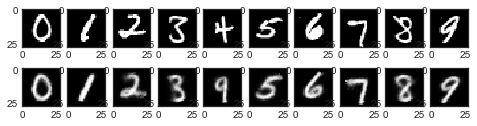

In [30]:
fig = plt.figure(figsize=(8,2))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(mnist_imgs[np.where(labels==i)[0][0]].reshape((28, 28)), 
               cmap=plt.cm.gray)
    plt.subplot(2,10,i+11)
    plt.imshow(decode[np.where(labels==i)[0][0]].reshape((28, 28)), 
               cmap=plt.cm.gray)
plt.show()

In the above figure the top row are sample digits from MNIST and the bottom row are the decoded images from our autoencoder. All digits besides 5 (which may be confused with 6) are easily recognizable.

### 2.2 Bone marrow data
We will now revisit an empirical set of mass cytometry data from bone marrow blood. From the project 2 outline:
>This is a mass cytometry dataset taken from Bendall et al. (2011). It is a sample of cells from the bone marrow measured with several protein markers. The bone marrow is where most of your blood cells develop and mature in a process known as hematopoeisis. The red blood cells, which are generally less interesting to immunologists have been removed, the remaining cells are white blood cells which constitute most of your immune response. These cells detect and fight invaders. Types of white blood cells included in this data set include
1. B cells (distinguished by the presence of the CD20 surface marker)
2. Helper T cells (distinguished by the presence of CD4)
3. Cytotoxic Killer T cells (distinguished by the presence of CD8)

> This data set contains 3,000 blood cells with 31 channels.

Here we will try to use our autoencoder to cluster the three cell types in the middle layer embedding. First we'll have to create a sampling method that preserves the indices of our training and testing data so that we can color our points by channel values later.

In [31]:
bonemarrow = load_json_files('gilman_ian_ps2/data/cytof_data.json')
channels = load_json_files('gilman_ian_ps2/data/cytof_channel_names.json')

In [32]:
def sample(array, size):
    '''Sample an array without replacement
    
    Parameters
    ----------
    array: nx2 array
    size: number of sample to take'''
    inds = np.random.choice(array.shape[0], size=size, replace=False)
    values = array[inds, :]
    return values, inds

In [33]:
def sample_w_rep(array, size):
    '''Sample an array with replacement
    
    Parameters
    ----------
    array: array
    size: number of sample to take'''
    inds = np.random.randint(array.shape[0], size=size)
    values = array[inds, :]
    return values, inds

In [34]:
def datasplit(data, ratio):
    '''Split data into training and testing subsets
    
    Parameters
    ----------
    data: array
    ratio: traing to testing ratio'''
    train_val, train_ind = sample(data, size=int(ratio*len(data)))
    mask = np.ones(len(data), dtype=bool)
    mask[train_ind] = False 
    test_ind = [i for i in range(len(mask)) if mask[i]==True]
    test_val = bonemarrow[mask]
    return train_val, train_ind, test_val, test_ind

Our autoencoder will roughly follow `autoencoder1`, above, but we'll implement our sampling method and change the output activation function from sigmoid to linear.

In [35]:
def autoencoder2(input_shape, output_shape, dataset, labels, 
                epochs=1000, batch_size=100, eta=0.001):
    '''An autoencoder that recreates MNIST digits.
    
    Parameters
    ----------
    input_shape: size of input vector
    output_shape: size of output vector
    dataset: dataset for traing/testing
    labels: labels associated with dataset
    epochs: number of training iterations
    batch_size: batch size for training
    eta: learning rate (default=0.001)
    
    Returns
    -------
    middle_out: middle layer embedding
    image_out: output image reconstructions
    batch_img: MNIST images used for testing
    labels: MNIST labels used for testing'''
    tf.reset_default_graph()
    train_val, train_ind, test_val, test_ind = datasplit(dataset, 0.8)
    
    input_img = tf.placeholder(name='input_img', 
                        shape=[None, input_shape], dtype=tf.float32)
    e1 = tf.tanh(layer_mult(input_img, input_shape, 1000), name='e1')
    e2 = tf.tanh(layer_mult(e1, 1000, 500), name='e2')
    e3 = tf.tanh(layer_mult(e2, 500, 250), name='e3')
    middle = layer_mult(e3, 250, 2)
    d1 = tf.tanh(layer_mult(middle, 2, 250), name='d1')
    d2 = tf.tanh(layer_mult(d1, 250, 500), name='d2')
    d3 = tf.tanh(layer_mult(d2, 500, 1000), name='d3')
    output_img = layer_mult(d3, 1000, output_shape)

    loss = tf.reduce_mean(
        tf.squared_difference(input_img, output_img), name='avg_loss')  
    train_step = tf.train.AdamOptimizer(eta).minimize(loss=loss)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in tqdm_notebook(range(epochs), leave=False):
            train_batch_img, train_batch_inds = sample_w_rep(
                                        train_val, batch_size)
            train_step.run(feed_dict={input_img:train_batch_img})

        middle_out = sess.run(middle, feed_dict={input_img:test_val})
        pred = np.asarray(middle_out)
        image_out = sess.run(output_img, feed_dict={input_img:test_val})
        
    return middle_out, image_out, test_val, test_ind

In [36]:
middle, image_out, test_vals, test_inds = autoencoder2(input_shape=31, 
    output_shape=31, dataset=bonemarrow, labels=channels, epochs=10000)

We can now visualize our embedding and compare it to our previous tSNE analysis.

In [37]:
bdists = pairwise_distances(bonemarrow)
tsne = TSNE(learning_rate=100).fit_transform(bdists)

In [38]:
cd4_ind = 5
cd8_ind = 6
cd20_ind = 9
cd4_col = [bonemarrow[i][cd4_ind] for i in test_inds]
cd8_col = [bonemarrow[i][cd8_ind] for i in test_inds]
cd20_col = [bonemarrow[i][cd20_ind] for i in test_inds]

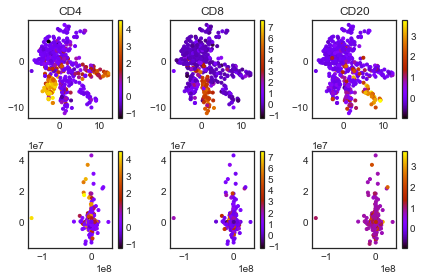

In [39]:
fig, ax = plt.subplots(2, 3, figsize=(6,4))
cd4plt = ax[0,0].scatter(x=middle[:,0], y=middle[:,1], 
                marker='.', c=cd4_col, cmap='gnuplot')
cd8plt = ax[0,1].scatter(x=middle[:,0], y=middle[:,1], 
                marker='.', c=cd8_col, cmap='gnuplot')
cd20plt = ax[0,2].scatter(x=middle[:,0], y=middle[:,1], 
                marker='.', c=cd20_col, cmap='gnuplot')
cd4cbar = plt.colorbar(cd4plt, ax=ax[0,0])
cd8cbar = plt.colorbar(cd8plt, ax=ax[0,1])
cd20cbar = plt.colorbar(cd20plt, ax=ax[0,2])

tsnecd4plt = ax[1,0].scatter(tsne[:,0], tsne[:,1], c=bonemarrow[:,cd4_ind], marker='.', cmap='gnuplot')
tsnecd8plt = ax[1,1].scatter(tsne[:,0], tsne[:,1], c=bonemarrow[:,cd8_ind], marker='.', cmap='gnuplot')
tsnecd20plt = ax[1,2].scatter(tsne[:,0], tsne[:,1], c=bonemarrow[:,cd20_ind], marker='.', cmap='gnuplot')
tsnecd4cbar = plt.colorbar(cd4plt, ax=ax[1,0])
tsnecd8cbar = plt.colorbar(cd8plt, ax=ax[1,1])
tsnecd20cbar = plt.colorbar(cd20plt, ax=ax[1,2])

ax[0,0].set_title('CD4')
ax[0,1].set_title('CD8')
ax[0,2].set_title('CD20')
plt.tight_layout()

In the plot above the top row shows the middle layer embedding from our autoencoder and the bottom row shows our previous tSNE plots, both colored by the channel noted above each column. Although our embedding does not clearly delineate the three cell types there are more obvious patterns and larger spread in the autoencoder embedding than tSNE. For both all three channels there is an arm with relatively high expression levels that may indicate differentiated cells. The cells that have relatively low expression may not be differntiated yet or may be at an earlier stage in the process, such as those in the right-extending arm in the CD4 autoencoder panel.

References

1. Andreatta, M. and Nielsen, M., 2015. Gapped sequence alignment using artificial neural networks: application to the MHC class I system. Bioinformatics, 32(4), pp.511-517.

2. Bendall, S. C., Simonds, E. F., Qiu, P., Amir, E.-A. D., Krutzik, P. O., Finck, R., et al. (2011). Single-cell mass cytometry of differential immune and drug responses across a human hematopoietic continuum. Science, 332(6030), 687–696.

3. Shen, Y. and Bax, A., 2013. Protein backbone and sidechain torsion angles predicted from NMR chemical shifts using artificial neural networks. Journal of biomolecular NMR, 56(3), pp.227-241.

In addition to the references above, naming and style conventions, TensorFlow help, and troubleshooting was greatly aided by Krishnan Srinivasan, Michael Nielson's site (http://neuralnetworksanddeeplearning.com), and the TensorFlow tutorials (http://tensorflow.org).